In [76]:
import torch 
import numpy as np
from score_models import ScoreModel
from tqdm import tqdm
from torch.func import vmap, grad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mpol.constants as const 
import os
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
path = "C:/Users/noedi/Desktop/Ciela/Code/Score_models/"
prior = "ncsnpp_probes_g_64_230604024652/" 
#prior = "ncsnpp_vp_skirt_y_64_230813225149/" 
#prior = "ncsnpp_vp_skirt_z_256_230813225243/"
#prior = "ncsnpp_ct_g_220912024942"
# Importing the weights
# score_model = ScoreModel(checkpoints_directory="/home/aadam/scratch/DeblendingGalaxies/models/ncsnpp_vp_probes_g_256_230824141338/")
# score_model = ScoreModel(checkpoints_directory="/home/aadam/scratch/DeblendingGalaxies/models/ncsnpp_vp_probes_z_256_230824141341/")
# score_model = ScoreModel(checkpoints_directory=path + prior)
# ground_truth = score_model.sample([5, 1, 64, 64], steps = 2000)


Using the Variance Exploding SDE


Sampling from the prior | t = 0.0 | sigma = 1.0e-03| scale ~ 1.1e+00: 100%|█████████▉| 1999/2000 [05:20<00:00,  6.23it/s]


In [17]:
S = torch.tensor(np.load("../interferometry2/data_htlup/sampling_function2.npy"))

In [57]:
import sys
sys.path.append("../interferometry2/diffusion-radio-astronomy/scripts/")

In [58]:
from uv_coverage import sim_uv_cov

In [112]:
grid, noise, u, v, _, _= sim_uv_cov(10)

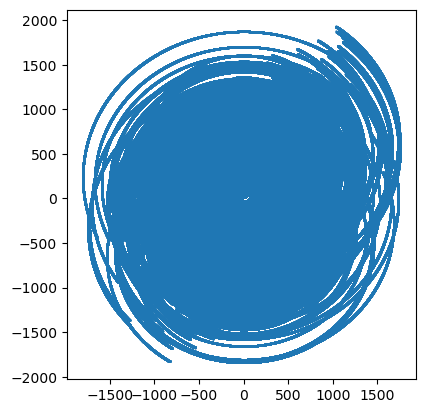

In [113]:
plt.scatter(u, v, s = 0.5)
plt.gca().set_aspect("equal")

In [131]:
def grid(pixel_scale, img_size): 
    """Given a pixel scale and a number of pixels in image space, grid the associated Fourier space

    Args:
        pixel_scale (float): Pixel resolution (in arcsec)
        img_size (float/int): Size of the image 

    Returns:
        
    """

    # Arcsec to radians: 
    dl = pixel_scale * const.arcsec
    dm = pixel_scale * const.arcsec

    du = 1 / (img_size * dl) * 1e-3 # klambda
    dv = 1 / (img_size * dm) * 1e-3 # klambda

    u_min = -img_size//2 * du 
    u_max = img_size//2 * du 

    v_min = -img_size//2 * dv
    v_max = img_size//2 * dv

    u_edges = np.linspace(u_min, u_max, img_size + 1)
    v_edges = np.linspace(v_min, v_max, img_size + 1)

    return u_edges, v_edges

pixel_scale = 0.015
#pad = 128#768//2 # padding up to 1024 pixels
pad = 0
#img_size = 256
npix = 256
u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = npix)

In [126]:
from scipy.stats import binned_statistic_2d

bin_x = u_edges
bin_y = v_edges
uu = np.concatenate([u, -u])
vv = np.concatenate([v, -v])
counts, _, _, _ = binned_statistic_2d(vv, uu, values = np.ones_like(uu), bins = (bin_y, bin_x), statistic = "count")

In [89]:
np.save("../../../../Desktop/sampling_function3.npy", S)

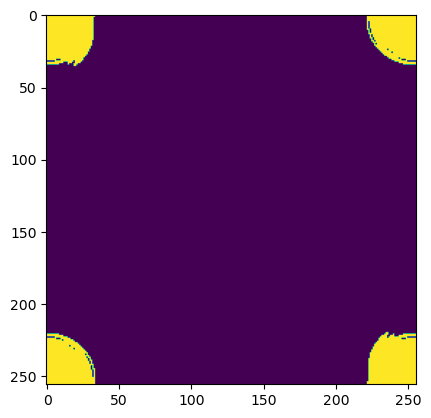

In [127]:
mask = counts>0.
S_grid = np.fft.fftshift(mask)
S_to_save = np.concatenate([S_grid.flatten(), S_grid.flatten()])
S = torch.tensor(S_to_save).to(device)
plt.imshow(S_grid)

Let's pad the ground-truth so that we can then apply the sampling function to it with our forward model

In [117]:
npix = 256
img_size = ground_truth.shape[-1]

def link_function(x): 
    return (x+1)/2

In [65]:
S.shape

torch.Size([131072])

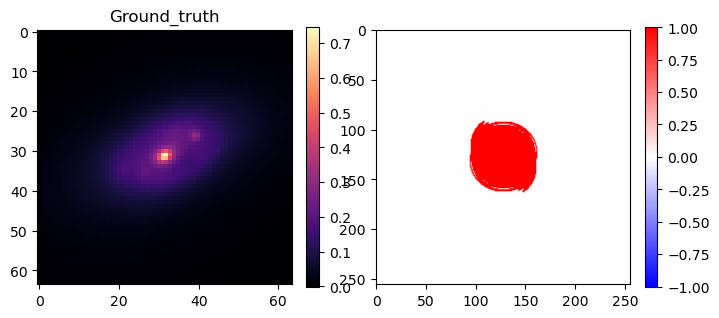

In [128]:
#norm = LogNorm(vmin = 1e-1)
norm = None

fig, axs = plt.subplots(1, 2, figsize = (2*4, 4))
im = axs[0].imshow(link_function(ground_truth[4, 0]).cpu().numpy(), norm = norm,  cmap = "magma")
axs[0].set_title("Ground_truth")
plt.colorbar(im, ax = axs[0], fraction = 0.046)

im = axs[1].imshow(torch.fft.fftshift(S[:256*256].reshape(256, 256)).cpu(), cmap = "bwr", vmin = -1)
plt.colorbar(im, ax = axs[1], fraction = 0.046)


In [133]:
def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x):
    return torch.fft.ifft2(x, norm = "ortho")

def sigma(t):
    return score_model.sde.sigma(t)

def mu(t):
    return score_model.sde.marginal_prob_scalars(t)[0]

C = 1 # VP prior
B = 0 # VP

C = 1/2 # VE
B = 1/2 # VE

def link_function(x):
    return C * x + B

def noise_padding(x, pad, sigma):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

img_size = 64
pad = (npix - img_size)//2
def model(x, t):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = noise_padding(x, pad=pad, sigma=sigma(t))
    x = link_function(x) # map from model unit space to real unit space
    vis_full = ft(x).flatten() 
    vis_sampled = vis_full
    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
    return vis_sampled[S]

sigma_y = 1e-2
idx = np.random.randint(low = 0, high = len(ground_truth))
x = ground_truth[idx]
y = model(x.flatten(), t = torch.zeros(1).to(device))

y += sigma_y * torch.randn_like(y)




In [130]:
x.shape

torch.Size([1, 64, 64])

In [5]:
t = torch.linspace(0, 1, 100)
sigma(t)

tensor([0.0000, 0.0335, 0.0654, 0.0971, 0.1288, 0.1602, 0.1914, 0.2223, 0.2529,
        0.2831, 0.3128, 0.3422, 0.3710, 0.3993, 0.4270, 0.4541, 0.4806, 0.5065,
        0.5317, 0.5562, 0.5799, 0.6030, 0.6252, 0.6468, 0.6675, 0.6875, 0.7067,
        0.7251, 0.7428, 0.7597, 0.7758, 0.7911, 0.8057, 0.8196, 0.8327, 0.8452,
        0.8569, 0.8680, 0.8784, 0.8882, 0.8973, 0.9059, 0.9139, 0.9214, 0.9283,
        0.9348, 0.9407, 0.9462, 0.9513, 0.9560, 0.9603, 0.9643, 0.9679, 0.9712,
        0.9743, 0.9770, 0.9795, 0.9817, 0.9838, 0.9856, 0.9873, 0.9888, 0.9901,
        0.9913, 0.9923, 0.9933, 0.9941, 0.9949, 0.9955, 0.9961, 0.9966, 0.9971,
        0.9975, 0.9978, 0.9981, 0.9984, 0.9986, 0.9988, 0.9990, 0.9991, 0.9993,
        0.9994, 0.9995, 0.9996, 0.9996, 0.9997, 0.9997, 0.9998, 0.9998, 0.9998,
        0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [33]:
mu(torch.ones(1).to(device))

tensor([1.], device='cuda:0')

In [138]:


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x, t)
    var = sigma(t) **2  + mu(t)**2 * sigma_y**2
    log_prob = -0.5 * torch.sum((mu(t) * y - y_hat)**2 / var)
    return log_prob

def score_likelihood(y, x, t, sigma_y): 
    x = x.flatten(start_dim = 1)
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)), randomness = "different")(x, t)

def score_posterior(y, x, t, sigma_y): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(y, x, t, sigma_y) 

def g(t, x):
    return score_model.sde.diffusion(t, x)

def drift_fn(t, x):
    return score_model.sde.drift(t, x)

def pc_sampler(y, sigma_y, num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma(t) * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps


    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(y, x, t, sigma_y)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(y, x, t, sigma_y)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            
    return link_function(x_mean).reshape(-1, 1, img_size, img_size), chain

def euler_sampler(y, sigma_y, num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma(t) * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps

    with torch.no_grad(): 
        for i in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(y, x, t, sigma_y)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

    return link_function(x_mean).reshape(-1, 1, img_size, img_size)

pred = 2000
corr = 1000
snr = 1e-2

num_samples = 2
# samples = euler_sampler(
#                     y = y,
#                     sigma_y = sigma_y,
#                     num_samples = num_samples,
#                     num_steps = pred, 
#                     score_function = score_posterior, 
#                     img_size = img_size
#                 )

samples, chain = pc_sampler(
                    y = y,
                    sigma_y = sigma_y,
                    num_samples = num_samples,
                    num_pred_steps = pred, 
                    num_corr_steps = corr,
                    snr = snr,
                    score_function = score_posterior, 
                    img_size = img_size
                )

  0%|          | 0/1999 [00:00<?, ?it/s]

100%|██████████| 1999/1999 [14:33<00:00,  2.29it/s]


In [74]:
len(samples)

1

IndexError: index 3 is out of bounds for axis 0 with size 3

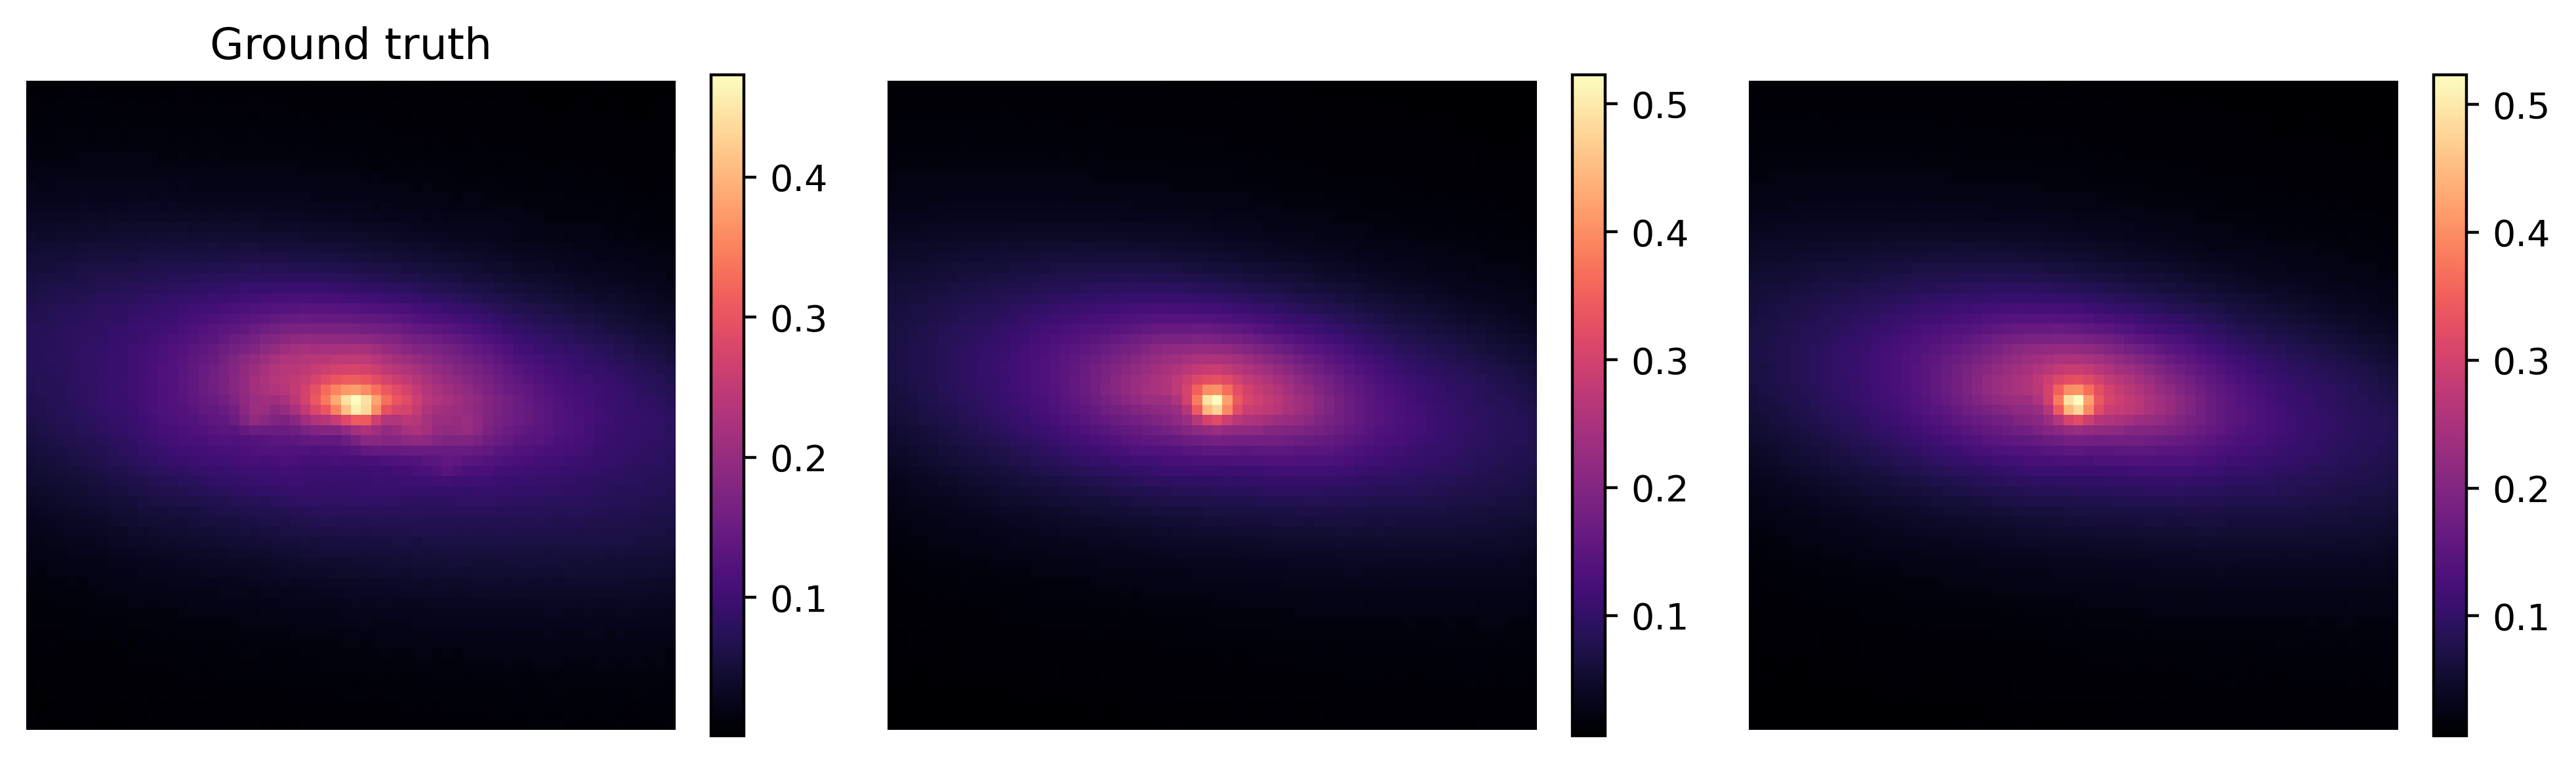

In [139]:


#norm = LogNorm(vmin=1e-3)
norm = None

# def link_function(x):
#     return (x+1)/2

if len(samples)==1: 
    fig, axs = plt.subplots(1, 2, figsize = (4 * 2, 4))
    im = axs[0].imshow(link_function(x.squeeze()).cpu(), cmap = "magma", norm = norm)
    plt.colorbar(im, fraction = 0.046)
    axs[0].set_title("Ground_truth")

    im = axs[1].imshow(samples.squeeze().cpu(), cmap = "magma", norm = norm)
    plt.colorbar(im, fraction = 0.046)
    axs[1].set_title("Posterior sample")
    
    for i in range(len(axs)):
        axs[i].axis("off")

    fig.suptitle(f"Pc sampling, pred = {pred}, corr = {corr}, snr = {snr}", y = 0.01)

else: 
    N = len(samples)
    fig, axs = plt.subplots(1, N+1, figsize = ((N+1) * 4, 4), dpi = 400)
    im = axs[0].imshow(link_function(x.squeeze()).cpu(), cmap = "magma", norm = norm)
    plt.colorbar(im, fraction = 0.046)
    axs[0].set_title("Ground truth")
    axs[0].axis("off")
    
    for j in range(N): 
        im = axs[j+1].imshow(samples[j].squeeze().cpu(), cmap = "magma", norm = norm)
        plt.colorbar(im, fraction = 0.046)
        axs[j+1].axis("off")
    axs[3].set_title("Posterior sample")

    #fig.suptitle(f"Pc sampling, pred = {pred}, corr = {corr}, snr = {snr}", y = 0.3)

plt.subplots_adjust(wspace = 0.3)

In [55]:
x.max()

tensor(3.9866, device='cuda:0')

In [29]:
link_function(x).sum()

tensor(180.2956, device='cuda:0')

In [30]:
samples.sum()

tensor(180.3453, device='cuda:0')

In [25]:
idx = "0"
path = "../Diagram/"

if not os.path.exists(path): 
    os.makedirs(path)
exp = "Test"

filename = os.path.join(path, exp) 

In [26]:
filename

'../Diagram/Test'